In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
np.random.seed(42)
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/drive/MyDrive/ITI113_Projects/Project/data/dataset v1.csv')

#Convert remaining_lease into numerical remaining_lease_years
def convert_lease_to_years(lease_str):
    if not isinstance(lease_str, str):
        return np.nan
    years = 0
    months = 0
    # Use regex to find numbers associated with 'year' and 'month'
    year_match = re.search(r'(\d+)\s*year', lease_str)
    month_match = re.search(r'(\d+)\s*month', lease_str)
    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))
    # Return the total lease in years, or NaN if no parts were found
    if years == 0 and months == 0:
        return np.nan
    return years + months / 12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_years)

#Ordinally encoded storey_range by taking the in-between storeys (floors 01-03 becomes 2)
floor_map = {'01 TO 03': 2,'04 TO 06': 5,'07 TO 09': 8,'10 TO 12': 11,'13 TO 15': 14,
    '16 TO 18': 17,'19 TO 21': 20,'22 TO 24': 23,'25 TO 27': 26,'28 TO 30': 29,
    '31 TO 33': 32,'34 TO 36': 35,'37 TO 39': 38,'40 TO 42': 41,'43 TO 45': 44,
    '46 TO 48': 47,'49 TO 51': 50,}

df['storey_ordinal'] = df['storey_range'].map(floor_map)

#Create train test splits
df.drop(columns=['Unnamed: 0','storey_range','street_name','remaining_lease','latitude','longitude','nearest_bus_stop','nearest_pei',
                   'nearest_jc','nearest_kindergarten','nearest_primary_school','nearest_secondary_school','nearest_poly',
                   'nearest_library','nearest_hospital','nearest_mall','nearest_mrt_station','nearest_sports_facility','nearest_hawker_centre'],inplace=True)
X = df.drop(columns=['resale_price'])
y = df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Sampling using Sample Weights
X_train['combined_feature'] = X_train['town'].astype(str) + '_' + \
                            X_train['flat_type'].astype(str) + '_' + \
                            X_train['flat_model'].astype(str)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train['combined_feature']  # The imbalanced feature we want to correct for
)

fit_params = {
    'regressor__sample_weight': sample_weights
}
X_train.drop(columns=['combined_feature'],inplace=True)

#One hot encode categorical columns and scale numerical columns by fit transforming on train data and transforming test data
categorical_columns = ['town', 'flat_type', 'flat_model']
numerical_columns = [
    'floor_area_sqm', 'lease_commence_date',
    'dist_bus_stop_m', 'dist_pei_m', 'dist_jc_m', 'dist_kindergarten_m',
    'dist_primary_school_m', 'dist_secondary_school_m', 'dist_poly_m',
    'dist_library_m', 'dist_mall_m', 'dist_hospital_m', 'dist_mrt_station_m',
    'dist_sports_facility_m', 'dist_hawker_centre_m',
    'remaining_lease_years','storey_ordinal',]


numerical_columns = [col for col in numerical_columns if col in X_train.columns]
categorical_columns = [col for col in categorical_columns if col in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

X_train_preprocess = preprocessor.fit_transform(X_train)
X_test_preprocess = preprocessor.transform(X_test)

#Scale y_train and y_test
scaler = QuantileTransformer(output_distribution='normal')
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled = scaler.fit_transform(y_train_reshaped)

print('Dataset preprocess complete')

Dataset preprocess complete


In [18]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
np.random.seed(42)
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/drive/MyDrive/ITI113_Projects/Project/data/dataset v1.csv')
print(df.columns.tolist())


['Unnamed: 0', 'month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price', 'latitude', 'longitude', 'nearest_bus_stop', 'dist_bus_stop_m', 'nearest_pei', 'dist_pei_m', 'nearest_jc', 'dist_jc_m', 'nearest_kindergarten', 'dist_kindergarten_m', 'nearest_primary_school', 'dist_primary_school_m', 'nearest_secondary_school', 'dist_secondary_school_m', 'nearest_poly', 'dist_poly_m', 'nearest_library', 'dist_library_m', 'nearest_mall', 'dist_mall_m', 'nearest_hospital', 'dist_hospital_m', 'nearest_mrt_station', 'dist_mrt_station_m', 'nearest_sports_facility', 'dist_sports_facility_m', 'nearest_hawker_centre', 'dist_hawker_centre_m']


In [19]:
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize CatBoost Regressor
cat_model = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=10,
    loss_function='RMSE',
    random_seed=42,
    verbose=200,
    early_stopping_rounds=200
)

# Train with sample weights
cat_model.fit(
    X_train_preprocess, y_train_scaled.ravel(),
    sample_weight=fit_params['regressor__sample_weight']
)

# Predictions
y_pred_scaled = cat_model.predict(X_test_preprocess)

# Inverse-transform predictions back to original price scale
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"CatBoost RMSE: {rmse:.2f}")
print(f"CatBoost MAE: {mae:.2f}")


0:	learn: 1.2472007	total: 53.6ms	remaining: 4m 27s
200:	learn: 0.3760210	total: 10.1s	remaining: 4m 1s
400:	learn: 0.2937708	total: 18.2s	remaining: 3m 29s
600:	learn: 0.2454187	total: 28s	remaining: 3m 25s
800:	learn: 0.2182633	total: 38.1s	remaining: 3m 19s
1000:	learn: 0.2005264	total: 46.2s	remaining: 3m 4s
1200:	learn: 0.1874320	total: 55.8s	remaining: 2m 56s
1400:	learn: 0.1778738	total: 1m 5s	remaining: 2m 48s
1600:	learn: 0.1701987	total: 1m 13s	remaining: 2m 37s
1800:	learn: 0.1642519	total: 1m 23s	remaining: 2m 28s
2000:	learn: 0.1594512	total: 1m 33s	remaining: 2m 19s
2200:	learn: 0.1551503	total: 1m 41s	remaining: 2m 8s
2400:	learn: 0.1515152	total: 1m 51s	remaining: 2m
2600:	learn: 0.1485229	total: 2m	remaining: 1m 51s
2800:	learn: 0.1459438	total: 2m 8s	remaining: 1m 41s
3000:	learn: 0.1435077	total: 2m 18s	remaining: 1m 32s
3200:	learn: 0.1412476	total: 2m 28s	remaining: 1m 23s
3400:	learn: 0.1391703	total: 2m 36s	remaining: 1m 13s
3600:	learn: 0.1372822	total: 2m 46s	r

In [ ]:
# Save CatBoost model in native format
cat_model.save_model("catboost_model.cbm")

# Save target scaler (since you used inverse_transform)
import joblib
joblib.dump(scaler, "scaler.pkl")




['scaler.pkl']

/tmp/ipython-input-704541162.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices = X_test.groupby(col).apply(
/tmp/ipython-input-704541162.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices = X_test.groupby(col).apply(
/tmp/ipython-input-704541162.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pan

--- Model Performance Report (RMSE) ---

----- RMSE by town -----
           town         RMSE
    BUKIT TIMAH 49963.531120
         BISHAN 45588.896954
     QUEENSTOWN 41635.259832
    BUKIT MERAH 40078.187080
   CENTRAL AREA 39611.021886
  MARINE PARADE 39191.263484
          BEDOK 35137.183695
        HOUGANG 34475.007393
       CLEMENTI 34303.426898
KALLANG/WHAMPOA 34250.678269
       TAMPINES 33563.066541
        GEYLANG 32775.424375
      TOA PAYOH 32093.509613
      SERANGOON 32053.212112
     ANG MO KIO 30868.060021
      PASIR RIS 29435.931512
    JURONG WEST 27352.455040
        PUNGGOL 26651.523774
    JURONG EAST 26353.453675
    BUKIT BATOK 26052.931811
  CHOA CHU KANG 25858.524359
  BUKIT PANJANG 25766.201075
      WOODLANDS 24379.413554
       SENGKANG 24209.150701
         YISHUN 22772.743311
      SEMBAWANG 19291.576932


----- RMSE by flat_type -----
       flat_type         RMSE
MULTI-GENERATION 52559.989910
       EXECUTIVE 44452.935878
          5 ROOM 37849.763233

/tmp/ipython-input-704541162.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')


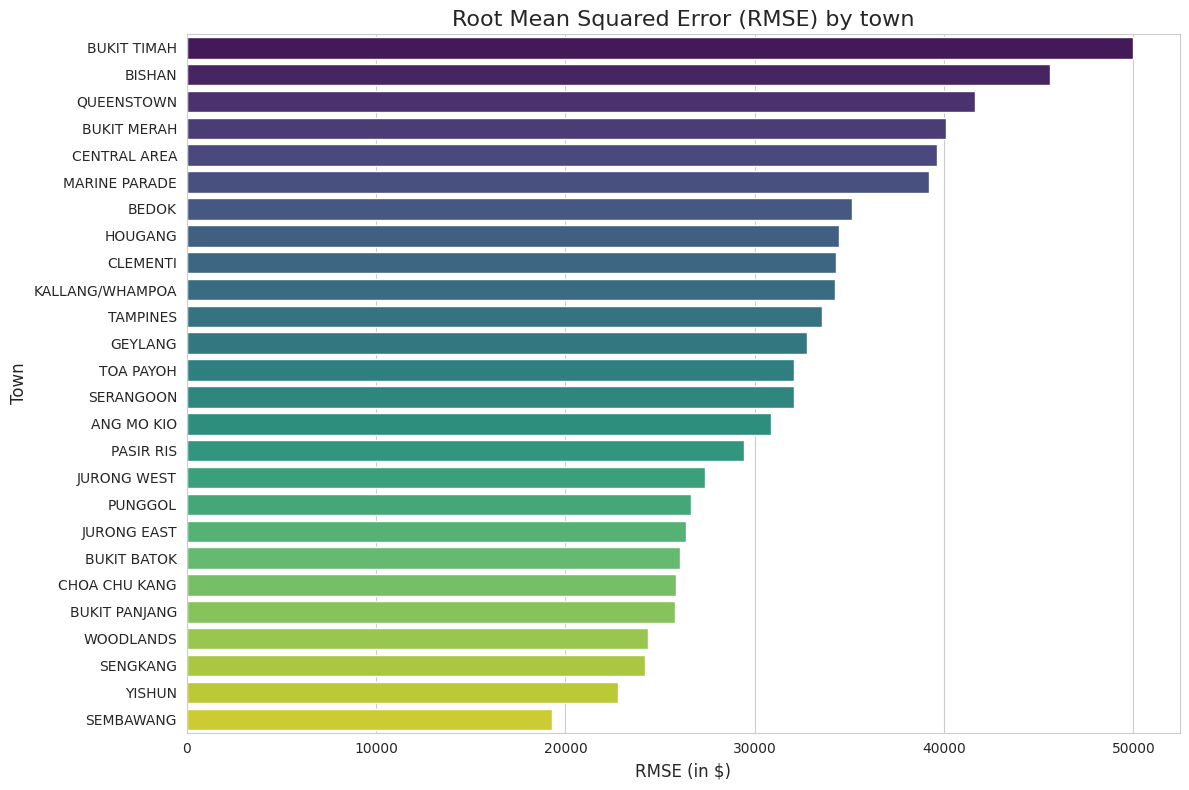

/tmp/ipython-input-704541162.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='RMSE', data=data_to_plot, palette='viridis')


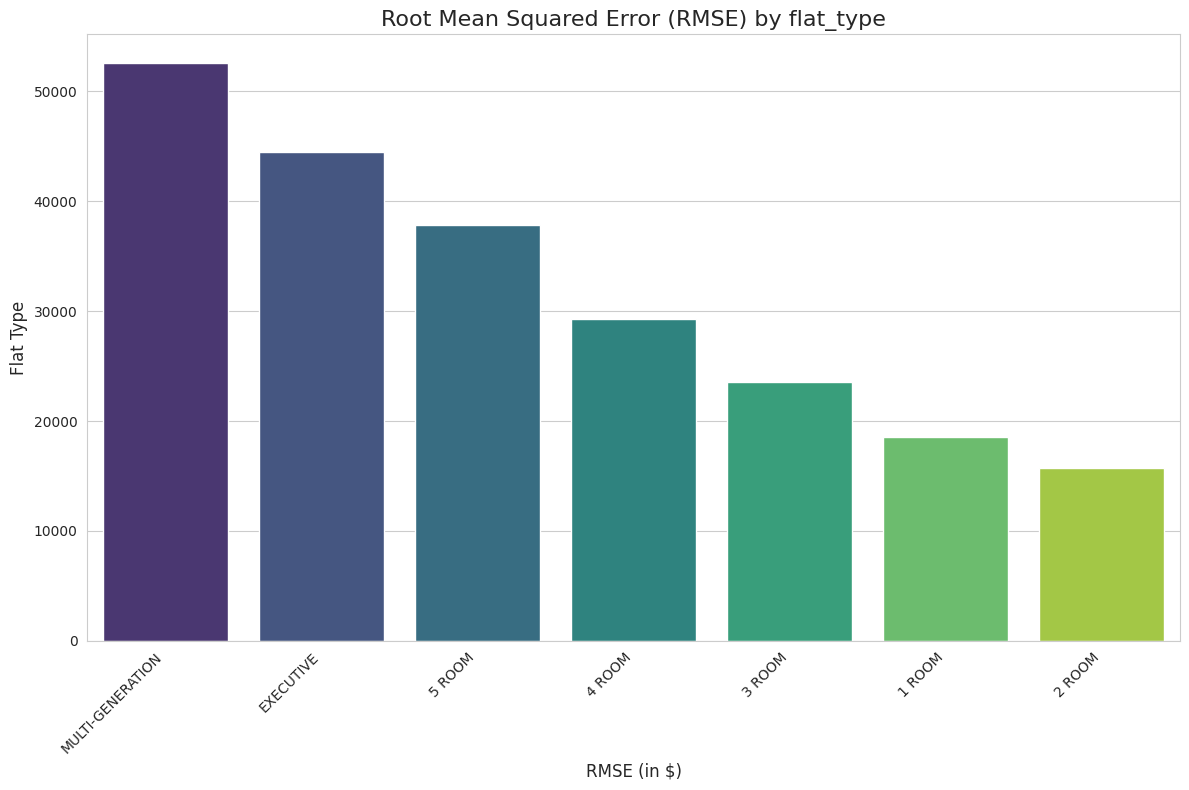

/tmp/ipython-input-704541162.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')


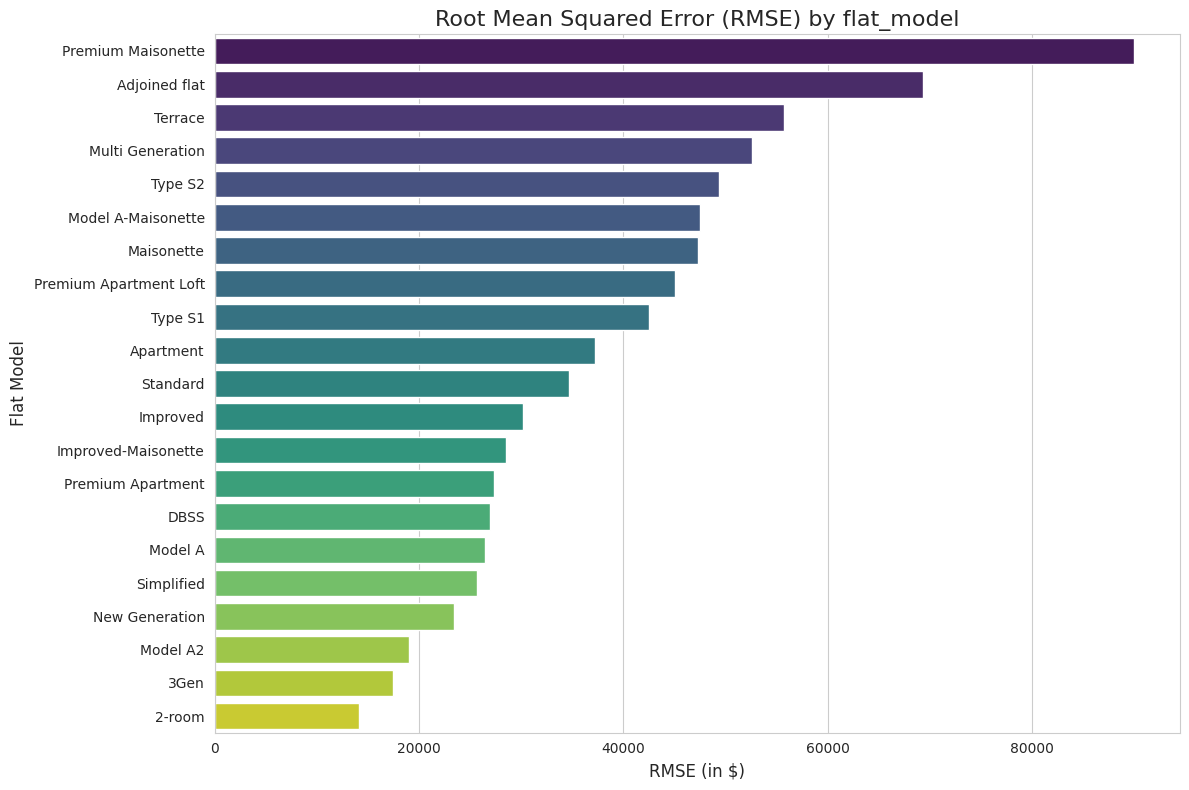

In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error

# Columns to sample from

sampling_cols = ['town', 'flat_type', 'flat_model']

all_indices = []

# Group by each column and sample 100 from each group

for col in sampling_cols:

    indices = X_test.groupby(col).apply(

        lambda x: x.sample(n=min(len(x), 100), random_state=42)

    ).index.get_level_values(1) # Get the original index

    all_indices.extend(indices)

# Get a set of unique indices to avoid duplicates

unique_indices = sorted(list(set(all_indices)))

# Create the final report datasets using the unique indices

X_classification_report = X_test.loc[unique_indices]

y_classification_report = y_test.loc[unique_indices]


def generate_model_report(model, preprocessor, y_scaler, X_report, y_report):

    # 1. Preprocess the report data and make predictions

    X_report_processed = preprocessor.transform(X_report)

    y_pred_scaled = model.predict(X_report_processed)

    # 2. Inverse transform predictions to get actual prices

    y_pred_scaled = y_pred_scaled.reshape(-1, 1)

    y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

    y_true = y_report.values

    # 3. Create a DataFrame for easy analysis

    results_df = X_report.copy()

    results_df['true_price'] = y_true

    results_df['predicted_price'] = y_pred

    results_df['squared_error'] = (results_df['true_price'] - results_df['predicted_price'])**2

    # Columns for which to generate reports

    report_cols = ['town', 'flat_type', 'flat_model']

    reports = {}

    print("--- Model Performance Report (RMSE) ---\n")

    # 4. Calculate RMSE for each class in each column

    for col in report_cols:

        rmse_by_class = results_df.groupby(col)['squared_error'].apply(lambda x: np.sqrt(x.mean()))

        report_df = rmse_by_class.reset_index(name='RMSE').sort_values('RMSE', ascending=False)

        reports[col] = report_df

        print(f"----- RMSE by {col} -----")

        print(report_df.to_string(index=False))

        print("\n" + "="*40 + "\n")

    # 5. Generate plots

    sns.set_style("whitegrid")

    for col in report_cols:

        plt.figure(figsize=(12, 8))

        # Sorting makes the chart easier to read

        data_to_plot = reports[col].sort_values('RMSE', ascending=False)

        # Adjust barplot orientation based on number of categories

        if len(data_to_plot) > 15:

            sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')

        else:

            sns.barplot(x=col, y='RMSE', data=data_to_plot, palette='viridis')

            plt.xticks(rotation=45, ha='right')

        plt.title(f'Root Mean Squared Error (RMSE) by {col}', fontsize=16)

        plt.xlabel('RMSE (in $)', fontsize=12)

        plt.ylabel(col.replace('_', ' ').title(), fontsize=12)

        plt.tight_layout()

        plt.show()

# --- Call the function to generate the full report ---

generate_model_report(

    model=cat_model,

    preprocessor=preprocessor,

    y_scaler=scaler,

    X_report=X_classification_report,

    y_report=y_classification_report

)


CatBoost RMSE: 28322.11
CatBoost MAE: 20866.13
------------------------------

--- Running Fairness Test ---
RMSE by Town:
                         rmse
town                         
ANG MO KIO       29508.174671
BEDOK            27393.802336
BISHAN           46945.114128
BUKIT BATOK      24356.660615
BUKIT MERAH      37957.150043
BUKIT PANJANG    24985.977849
BUKIT TIMAH      49173.866844
CENTRAL AREA     34534.886946
CHOA CHU KANG    24055.408716
CLEMENTI         29383.785126
GEYLANG          29531.793226
HOUGANG          29840.924757
JURONG EAST      27706.579820
JURONG WEST      24390.106259
KALLANG/WHAMPOA  32511.435854
MARINE PARADE    39869.369289
PASIR RIS        29669.286312
PUNGGOL          25623.327612
QUEENSTOWN       37355.987187
SEMBAWANG        21863.132313
SENGKANG         24339.024037
SERANGOON        32771.584947
TAMPINES         27561.441354
TOA PAYOH        33605.392812
WOODLANDS        23742.991301
YISHUN           23690.540737


Difference in RMSE between towns: $

  0%|          | 0/100 [00:00<?, ?it/s]

Displaying SHAP Summary Plot...


/tmp/ipython-input-3060937348.py:73: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample, show=False)


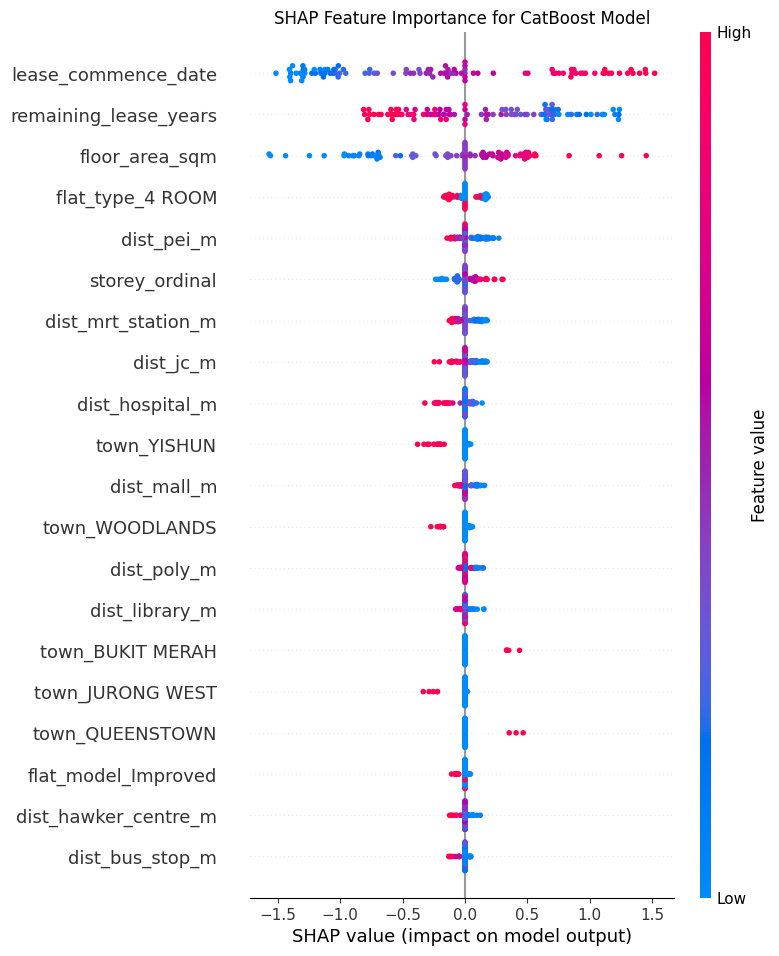

------------------------------

--- Running Robustness Test ---
Original Test Set RMSE: $28322.11
Perturbed Test Set RMSE: $30287.78
RMSE increased by: $1965.67 (6.94%)
Average prediction change after perturbation: $7084.22
------------------------------



In [21]:
# --- Install Dependencies ---
!pip install fairlearn shap catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from fairlearn.metrics import MetricFrame
import shap

# --- Helper Function ---
def rmse(y_true, y_pred):
    """Calculates Root Mean Squared Error."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --- 1. Scale Test Target ---
# If y_train was scaled, scale y_test using the same scaler
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
y_test_actual = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# --- 2. Predictions with CatBoost ---
y_pred_scaled = cat_model.predict(X_test_preprocess)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate
original_rmse = rmse(y_test_actual, y_pred)
original_mae = np.mean(np.abs(y_test_actual - y_pred))
print(f"CatBoost RMSE: {original_rmse:.2f}")
print(f"CatBoost MAE: {original_mae:.2f}")
print("-" * 30 + "\n")

# --- 3. Fairness Test: RMSE by Town ---
print("--- Running Fairness Test ---")
sensitive_features = X_test['town']  # Use original DataFrame with 'town'

grouped_on_town = MetricFrame(
    metrics={'rmse': rmse},
    y_true=y_test_actual,
    y_pred=y_pred,
    sensitive_features=sensitive_features
)

print("RMSE by Town:")
print(grouped_on_town.by_group)
print("\n")

difference_value = grouped_on_town.difference(method='between_groups')['rmse']
print(f"Difference in RMSE between towns: ${difference_value:.2f}")
print("-" * 30 + "\n")

# --- 4. Explainability Test: SHAP ---
print("--- Running Explainability Test (SHAP) ---")
print("This may take a moment...")

# Reconstruct feature names from preprocessor
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
feature_names = numerical_columns + list(ohe_feature_names)

# Convert preprocessed arrays to DataFrames for SHAP
X_train_df = pd.DataFrame(X_train_preprocess, columns=feature_names)
X_test_df = pd.DataFrame(X_test_preprocess, columns=feature_names)

# Use a sample of training data for KernelExplainer background
background = shap.sample(X_train_df, 50, random_state=42)
explainer = shap.KernelExplainer(cat_model.predict, background)

# Sample 100 test rows for SHAP values
X_test_sample = X_test_df.sample(100, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Plot SHAP summary
print("Displaying SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title("SHAP Feature Importance for CatBoost Model")
plt.show()
print("-" * 30 + "\n")

# --- 5. Robustness Test: Floor Area Perturbation ---
print("--- Running Robustness Test ---")
X_test_perturbed = X_test.copy()
perturbation_factor = np.random.uniform(0.95, 1.05, size=X_test_perturbed.shape[0])
X_test_perturbed['floor_area_sqm'] *= perturbation_factor

# Transform perturbed data using the same preprocessor
X_test_perturbed_processed = preprocessor.transform(X_test_perturbed)

# Make predictions on perturbed data
y_pred_perturbed_scaled = cat_model.predict(X_test_perturbed_processed)
y_pred_perturbed = scaler.inverse_transform(y_pred_perturbed_scaled.reshape(-1, 1)).ravel()

# Compare RMSE
perturbed_rmse = rmse(y_test_actual, y_pred_perturbed)
print(f"Original Test Set RMSE: ${original_rmse:.2f}")
print(f"Perturbed Test Set RMSE: ${perturbed_rmse:.2f}")
print(f"RMSE increased by: ${perturbed_rmse - original_rmse:.2f} "
      f"({((perturbed_rmse - original_rmse) / original_rmse) * 100:.2f}%)")

# Average absolute change in predictions
avg_change = np.mean(np.abs(y_pred - y_pred_perturbed))
print(f"Average prediction change after perturbation: ${avg_change:.2f}")
print("-" * 30 + "\n")
